In [1]:
import tensorflow as tf
import torch
# transformers ver >= 4.8.2
from transformers import BertTokenizer, BertForSequenceClassification 
from sklearn import preprocessing


from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from transformers.optimization import Adafactor, AdafactorSchedule
from tqdm.notebook import tqdm
import os

In [2]:
device = torch.device("cuda")

In [3]:
df = pd.read_csv("text_series_full.csv", delimiter=',')

In [4]:
df = df[['text', 'class']]
df['text'] = df['text'].apply(lambda x: ' '.join(x.split(' ')[:10]))
df = df.dropna()
df.head(10)

,text,class
0,трамп клинтон выиграли праймериз аризоне проиг...,world
1,Госдума утвердила введение присяги вступлении ...,politics
2,черная дыра роскосмоса откуда берутся заоблачн...,politics
3,уганде родители пытались убить дочь переход ис...,religion
4,Белгородский захватчик банка получил года коло...,politics
5,будущей верховной раде видны контуры правящей ...,politics
6,крах вимавиа эксперты дали советы клиентам оск...,society
7,очень интересное затмение прошедшее солнечное ...,science
8,меркель оценила сдержанную реакцию украины вво...,world
9,протест ученых против кафедры теологии мифи св...,religion


In [15]:
df.shape

(407584, 2)

In [5]:
le = preprocessing.LabelEncoder()
df['class'] = le.fit_transform(df['class'])

In [6]:
df['class'].value_counts()

6    162184
2    113942
5     51555
4     45519
3     22518
0      6610
1      5256
Name: class, dtype: int64

In [7]:
# Будем предсказывать typeid

texts = df['text'].values
labels = df['class'].values

In [13]:
# Токенизируем все names

def encode(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      
                        add_special_tokens = True, 
                        max_length = 32,          
                        pad_to_max_length = True,
                        return_tensors = 'pt',
                        truncation = True,
                        padding='max_length'
                   )
    
    return encoded_dict['input_ids']
    
input_ids = list(map(lambda text: encode(text), tqdm(texts)))

input_ids = torch.cat(input_ids, dim=0)
labels = torch.tensor(labels)

print('Original: ', texts[0])
print('Token IDs:', input_ids[0])


Original:  трамп клинтон выиграли праймериз аризоне проиграли кокусы юте айдахо трамп
Token IDs: tensor([   101,  11166,    388,  22061,   2297,  19672,    925,   1622,  54174,
           396, 115556,  16630,  23766, 115012,    974,  87707,    376, 110183,
          3830,    375,  11166,    388,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0])


In [ ]:
torch.save(input_ids, 'input_ids.pt')
torch.save(labels, 'labels.pt')

In [3]:
input_ids = torch.load('input_ids')
labels = torch.load('labels.pt')

In [4]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size=0.3, random_state=42)

In [5]:
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size 
        )

val_dataset = TensorDataset(X_val, y_val)

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size
        )

In [6]:
model = BertForSequenceClassification.from_pretrained(
    "sberbank-ai/ruBert-base",
    num_labels = 7
)

model.cuda()

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not in

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [7]:
optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8 
                )

In [9]:
epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [10]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [11]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [12]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)

        model.zero_grad()        

        m = model(b_input_ids, 
                             token_type_ids=None, 
#                              attention_mask=b_input_mask, 
                             labels=b_labels)

        loss, logits = m['loss'], m['logits']
        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)

        with torch.no_grad():        
            m = model(b_input_ids, 
                                   token_type_ids=None, 
#                                    attention_mask=b_input_mask,
                                   labels=b_labels)
            
            loss, logits = m['loss'], m['logits']
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  8,916.    Elapsed: 0:00:09.
  Batch    80  of  8,916.    Elapsed: 0:00:18.
  Batch   120  of  8,916.    Elapsed: 0:00:27.
  Batch   160  of  8,916.    Elapsed: 0:00:36.
  Batch   200  of  8,916.    Elapsed: 0:00:45.
  Batch   240  of  8,916.    Elapsed: 0:00:54.
  Batch   280  of  8,916.    Elapsed: 0:01:03.
  Batch   320  of  8,916.    Elapsed: 0:01:12.
  Batch   360  of  8,916.    Elapsed: 0:01:21.
  Batch   400  of  8,916.    Elapsed: 0:01:31.
  Batch   440  of  8,916.    Elapsed: 0:01:40.
  Batch   480  of  8,916.    Elapsed: 0:01:49.
  Batch   520  of  8,916.    Elapsed: 0:01:58.
  Batch   560  of  8,916.    Elapsed: 0:02:07.
  Batch   600  of  8,916.    Elapsed: 0:02:17.
  Batch   640  of  8,916.    Elapsed: 0:02:26.
  Batch   680  of  8,916.    Elapsed: 0:02:35.
  Batch   720  of  8,916.    Elapsed: 0:02:44.
  Batch   760  of  8,916.    Elapsed: 0:02:54.
  Batch   800  of  8,916.    Elapsed: 0:03:03.
  Batch   840  of

In [13]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.45,0.36,0.87,0:34:23,0:03:55
2,0.26,0.37,0.87,0:34:27,0:03:54
3,0.15,0.45,0.87,0:34:27,0:03:55


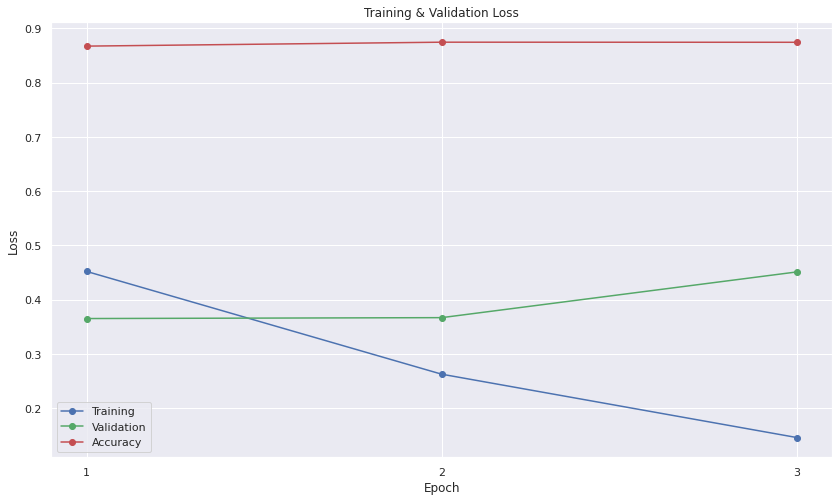

In [14]:
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (14,8)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Accuracy")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(1, epochs + 1))

plt.show()